In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

print("NumPy version:", np.__version__)
#print("Matplotlib version:", matplotlib.__version__)
print("Pandas version:", pd.__version__)
print("PyTorch version:", torch.__version__)

NumPy version: 1.24.3
Pandas version: 2.0.3
PyTorch version: 2.1.1


##### let's explore the data first

In [2]:
# Load the training data
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

# Display the first few rows of the dataset
#print("First few rows of the dataset:")
#print(train_data.head())
# Check the shape of the dataset
print("\nShape of the dataset:", train_data.shape)
# Statistical summary
#print("\nStatistical summary of the dataset:")
#print(train_data.describe())


Shape of the dataset: (42000, 785)


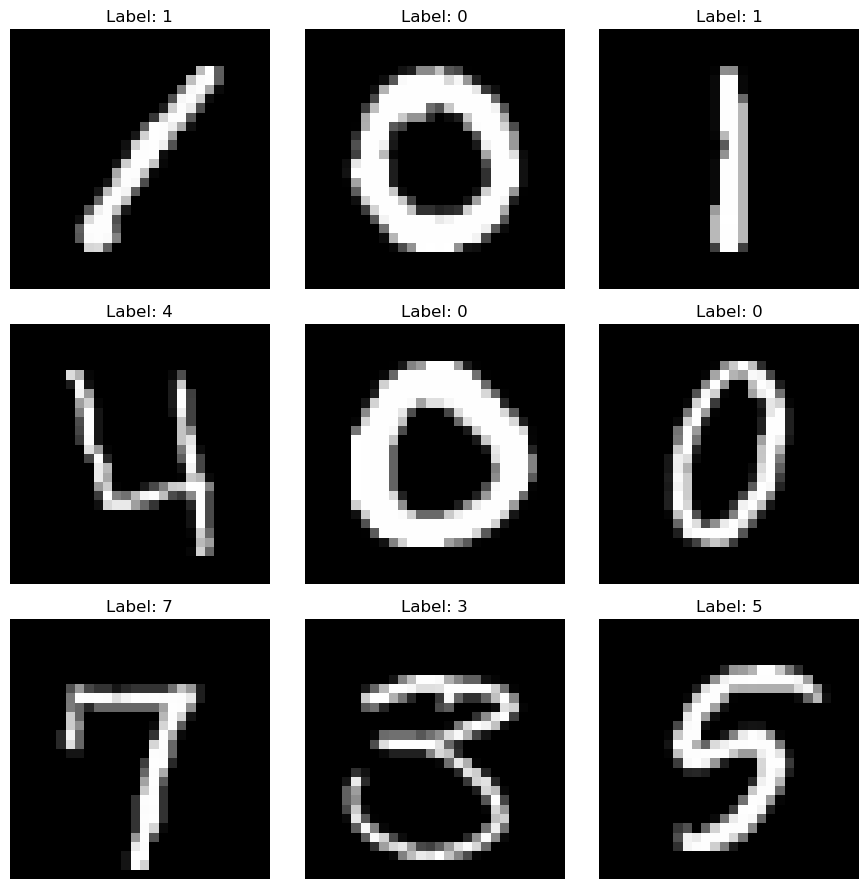

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    img = train_data.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {train_data.iloc[i, 0]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


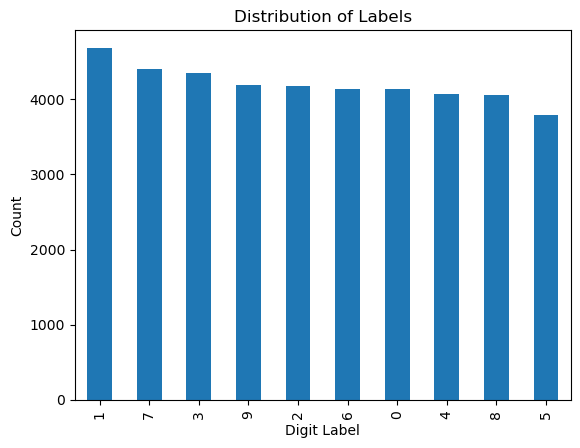

In [4]:
# Plot the distribution of labels
train_data['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Digit Label')
plt.ylabel('Count')
plt.show()

In [5]:
# Extract features and labels
# Reshape images to (n_samples, channels, height, width)
features = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0
labels = train_data.iloc[:, 0].values


# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)


# Prepare the test data
test_features = test_data.values.reshape(-1, 1, 28, 28) / 255.0
test_features = torch.tensor(test_features, dtype=torch.float32)

# Create Tensor Datasets
train_dataset = TensorDataset(features, labels)
test_dataset = TensorDataset(test_features)

# Define the size for the validation set
val_size = int(0.2 * len(train_dataset))  # 20% for validation
train_size = len(train_dataset) - val_size

# Splitting the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define the batch size
batch_size = 64

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class SimpleFCNN(nn.Module):
    def __init__(self):
        super(SimpleFCNN, self).__init__()

        #Flatten image from 28*28 to 784 elemet vector
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
    
model = SimpleFCNN()

In [7]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)  # Learning rate scheduler

# Parameters for training
num_epochs = 10
early_stopping_patience = 3  # Number of epochs to wait for improvement before stopping
min_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Adjust learning rate
    scheduler.step()

    # Validation loss
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Early stopping
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0  # reset counter if validation loss improves
    else:
        patience_counter += 1

    if patience_counter > early_stopping_patience:
        print("Stopping early due to no improvement in validation loss")
        break

Epoch [1/10], Train Loss: 1.3389, Validation Loss: 1.2380
Epoch [2/10], Train Loss: 1.2178, Validation Loss: 1.2129
Epoch [3/10], Train Loss: 1.1908, Validation Loss: 1.1991
Epoch [4/10], Train Loss: 1.1735, Validation Loss: 1.1994
Epoch [5/10], Train Loss: 1.1648, Validation Loss: 1.1937
Epoch [6/10], Train Loss: 1.1589, Validation Loss: 1.1924
Epoch [7/10], Train Loss: 1.1555, Validation Loss: 1.1907
Epoch [8/10], Train Loss: 1.1532, Validation Loss: 1.1945
Epoch [9/10], Train Loss: 1.1520, Validation Loss: 1.1929
Epoch [10/10], Train Loss: 1.1511, Validation Loss: 1.1960


In [8]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Validation Accuracy: {} %'.format(100 * correct / total))

Validation Accuracy: 50.11904761904762 %


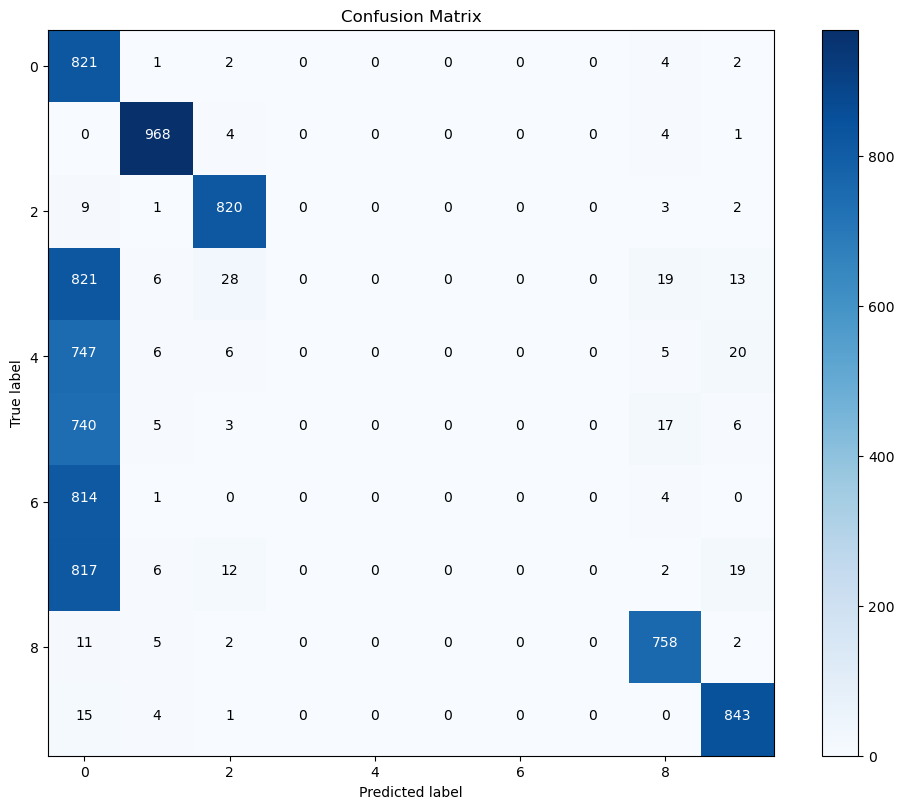

In [9]:
# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [10]:
model.eval()  # Set the model to evaluation mode
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        images = batch[0]  # Get the images from the batch
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.tolist())